##  Step 1 Generate sim_rates

In [3]:
import pandas as pd
import numpy as np
import os

In [6]:
"""
using swap rate to construct DFT curve
"""
corr=pd.read_excel("fwd_rates_correl.xlsx", sheet_name ="change_corr").to_numpy()[1:,1:]
curve = pd.read_excel("values of swaptions_and_bermudan_v4.xlsx", sheet_name ="cms")

In [8]:
from scipy import interpolate, stats, optimize
#fit cubic spline to curve to get other maturities
maturities = np.arange(1, 21)*0.5
cs = interpolate.CubicSpline(curve["tenor"], curve["swap rate"])
cms = np.array(pd.DataFrame({"maturity" : maturities,"rate" : cs(maturities)/100}))
par=cms[:,1]

# boostrap discount prices from par rate
DFT=np.zeros(cms.shape[0])
DFT[0]=1/(1+par[0]/2)
for i in range(1,20):
    DFT[i]=(1-par[i]/2 * np.sum(DFT))/(par[i]/2+1) 


#decompose historical correlation matrix
eig_vec = np.linalg.eig(corr)[1]
eig_inv = np.linalg.inv(eig_vec)

In [10]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


In [53]:
def smm(initial_curve, corr, paths, factors, eig):
    """
    Args:
     initial_curve :the initial discount curve bootstrapped from cms
     corr : historical correlation matrix (19x19) (1 less than # of semi-annual discount bonds available)
     paths : number of simulated rate paths
     factors : number of factors affecting the correlation
     eig : new eigen values that generates the correlation
    """
    N = 20
    step = 21
    paths = int(paths)
    rates = np.zeros((N, step, paths))
    rates[:,0,:] = initial_curve.reshape(N, 1) #initial discount vector
    np.random.seed(345)
    
    for i in range(1,step):
        row = i-1 #matured row (as next time step shortest dated bond matures)
        rates[row,i,:] = 1 #worth par when they mature
        
        #find r
        #shortest dated rate
        r = (rates[row,i-1,:]**(-1) - 1)*2
        
        #new eigen values:
        new_eig = np.zeros((N-1,N-1))
        factors = factors #number of factors
        new_eig_val = np.concatenate((eig, np.repeat(1e-10, N-1-factors)), axis = 0) #to make sure it's positive definite
        new_eig[np.diag_indices(N-1)] = new_eig_val
        
        #create new covariance matrix
        
        cov_mat = np.dot(np.dot(eig_vec, new_eig), eig_inv)        
        #cholesky decomposition for correlated variables
        # cor_mat=correlation_from_covariance(cov_mat)
        # chol=np.linalg.cholesky(cor_mat)
        
        # #cholesky decomposition for correlated variables
        chol = np.linalg.cholesky(cov_mat) #lower triangular L
        
        #vol of forward curves
        vol = np.sqrt(np.diag(cov_mat))
#        vol=vol_test/100
        #Time-Homogeneous (TH)
        vol = vol[0:(N-i)].reshape(-1,1) #first 19, 18, 17, ...
        
        #simulate correlated brownian paths
        #w/ anti thetic variates
        z = np.random.normal(size = (int(np.ceil(paths/2)), (N-1) ))
        z = np.r_[z, -z][0:paths,:] #anti-thetic
        
        #grab relevant dwt (cut down last vectors)
        dwt = chol @ z.T #result: dwt = (N x simulated paths)
        dwt = dwt[0:(N-i),:] #first 19, 18, 17, ...
        
        #calculate forward rates from previous vector of discount rates:
        forward = 2 * ((rates[row:-1, i-1 ,:] / rates[(row+1):, i-1 ,:]) - 1)
        
        #get jacobian matrix
        di = np.diag_indices(N-i)
        jacobian = np.zeros((N-i, N-i, paths))
        #fill main diagonal
        diags = (rates[row:-1, i-1 ,:]) / -(rates[(row+1):, i-1 ,:])**2
        jacobian[di] = diags
        
        #fill offset diagonal
        di = (di[0][1:], di[1][:-1])
        diags = 1/(rates[(row + 2):, i-1 ,:]) #row+2
        jacobian[di] = diags
        
        #inverse
        inv_jacobian = np.linalg.inv(jacobian.T).T
        
        # =============================================================================
        # evolve
        # dD = rD(i-1) * (1/2) + J**-1 * F * vol * dwt * sqrt(0.5)
        # =============================================================================  
        #diffusion
        diffusion = np.einsum('ijk,jk->ik', inv_jacobian, forward*vol)
        # check 
        all(np.allclose( diffusion[:, j].reshape(-1,1) , inv_jacobian[:,:,j] @ (forward[:,j].reshape(-1,1) * vol) ) for j in range(paths) )
                                              
        rates[(row+1):,i,:] = (rates[(row+1):,i-1,:] + r * rates[(row+1):,i-1,:] * 0.5 +
                                diffusion * dwt * np.sqrt(0.5))        
    return rates

In [54]:
para=np.array([1.24445565e+00, 1.03384821e-01, 7.25724878e-02, 7.00277649e-03]) 

sim_rates=smm(DFT, corr, 5000, len(para),para)
sim_rates_10k=smm(DFT, corr, 10000, len(para),para)
sim_rates_50k=smm(DFT, corr, 50000, len(para),para)
sim_rates_100k=smm(DFT, corr, 100000, len(para),para)

In [18]:
sim_rates[:5,:5,1]

array([[0.99861392, 1.        , 0.        , 0.        , 0.        ],
       [0.99759357, 0.99896366, 1.        , 0.        , 0.        ],
       [0.99652022, 0.99785927, 0.99904042, 1.        , 0.        ],
       [0.99554908, 0.99682642, 0.99812227, 0.99897508, 1.        ],
       [0.99447329, 0.99565606, 0.99709571, 0.99783977, 0.99916139]])

###  Step 2 Price a swaption using LSM

In [21]:
def ContinuationValue(x,method,k,y):
    L=np.zeros(shape=(k,len(x)))
    b=np.zeros(k)
    if method=="Hermite":
        L[0,:]=np.ones_like(x)
        L[1,:]= 2*x
        for i in range(2,k):
            L[i,:]=2*x*L[i-1,:]-2*(i-1)*L[i-2,:]
    if method=="Laguerre":
        if k==2:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
        if k==3:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
            L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
        if k==4:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
            L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
            L[3,:]=np.exp(-x/2)*(1-3*x+3/2*np.power(x,2)-1/6*np.power(x,3))
    if method=="Monomials":
        for i in range(0,k):
            L[i,:]=np.power(x,i)
    A=np.zeros(shape=(k,k))
    for i in range(0,k):
        b[i]=np.sum(y*L[i,:])
        for j in range(0,k):
            A[j,i]=np.sum(L[i,:]*L[j,:])
    a= np.dot(np.linalg.inv(A),b)
    V=np.sum(L*a[:,np.newaxis],axis=0)# sum cols
    return  V.reshape((-1,1))

In [122]:
def Laguerre_feature(x,k):
#    x=ev.ravel()
#    k=3
    L=np.zeros(shape=(k,len(x)))
    if k==2:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
    if k==3:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
        L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
    if k==4:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
        L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
        L[3,:]=np.exp(-x/2)*(1-3*x+3/2*np.power(x,2)-1/6*np.power(x,3))
    return L.T

In [123]:
from sklearn.linear_model import Lasso
def lasso_regressor(x,y,alpha):
    lassoreg = Lasso(fit_intercept=False,alpha=alpha,normalize=True, max_iter=1e3)
    lassoreg.fit(x,y)
    y_pred = lassoreg.predict(x)
    return y_pred


In [127]:
def Bermudan_swaption_lsm(lockout,maturity,sim_rates,strike,alpha):    
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix
    value_mat=np.zeros((paths,step)) # value_mat 5000*18
    index_mat=np.zeros((paths,step)) # value_mat 5000*18
    payoff_mat=np.zeros_like(value_mat) # value_mat 5000*18
       
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100
    
    index_mat[:,-1]=np.where(payoff_mat[:,-1]>0,1,0) #5000*1
    value_mat[:,-1]=payoff_mat[:,-1] # 5000*1
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_mat[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=3).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
#        
        # linear regression
        cv_hat=lasso_regressor(basis,cv,alpha).reshape((paths,1))
        value_mat[:,i]=np.where(ev>cv_hat,ev,cv_hat).ravel()
        index_mat[:,i]=np.where(ev>cv_hat,1,0).ravel()
        
        for j in range(i+1,index_mat.shape[1]):
            index_mat[:,j][index_mat[:,int(i)]==1]=0
        
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_LSM':np.sum(index_mat,axis=0)/paths})
             

    price_lsm=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_mat,payoff_mat)),axis=1)*cmmf)    
    return Euro_prc,price_lsm,prob

In [128]:
## for test 10 nc 1    
lockout=1
maturity=10
strike=0.008
alpha=0.1


In [129]:
%%time
prc_lsm=Bermudan_swaption_lsm(lockout,maturity,sim_rates,strike,alpha)

Wall time: 182 ms


In [130]:
print('European swaption pirce: {}'.format(prc_lsm[0]))

European swaption pirce: 0.006939140046653583


In [131]:
print('American swaption pirce: {}'.format(prc_lsm[1]))

American swaption pirce: 0.007343281609609181


In [132]:
print('Excercise Probability Table')
prc_lsm[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_LSM
0,2,0.708,0.7080
1,3,0.000,0.0432
2,4,0.000,0.0200
3,5,0.000,0.0104
4,6,0.000,0.0066
5,7,0.000,0.0052
6,8,0.000,0.0048
7,9,0.000,0.0024
8,10,0.000,0.0028
9,11,0.000,0.0024


##  Step 3 Train NN model

In [67]:
import torch
import torch.optim as optim
import time

In [17]:
def trainNN(basis,cv,n_epochs,batch_size,learningrate):
    x_train=torch.tensor(basis,dtype=torch.float)    
    y_train=torch.tensor(cv,dtype=torch.float)
    features_num=int(basis.shape[1])
# define a model    
    model=torch.nn.Sequential(
            torch.nn.Linear(features_num,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,1))# n values
    
    optimizer=optim.Adam(model.parameters(),lr=learningrate)
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train.view(-1,1))
    
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    for epoch in range(n_epochs):
        for i, (features, cv_value) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(features.float())
            loss = torch.nn.functional.mse_loss(output,cv_value)
            loss.backward()
            optimizer.step()
                        
    y_train_hat =np.squeeze(model(x_train)).detach().numpy().reshape((cv.shape[0],-1))
    return y_train_hat

In [72]:
def Bermudan_swaption_nn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate):
   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_rlnn,index_rlnn=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100

    
    index_rlnn[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_rlnn[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_rlnn[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].T.reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1 
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=3).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress now NN
        cv_rlnn=trainNN(basis,cv,n_epochs,batch_size,learningrate)
        value_rlnn[:,i]=np.where(ev>cv_rlnn,ev,cv_rlnn).ravel()
        index_rlnn[:,i]=np.where(ev>cv,1,0).ravel()
        
        for j in range(i+1,index_rlnn.shape[1]):            
             index_rlnn[:,j][index_rlnn[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_RLNN':np.sum(index_rlnn,axis=0)/paths})

    price_rlnn=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_rlnn,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_rlnn,prob

In [73]:
## for test 10 nc 1

lockout=1
maturity=10
strike=0.008
learningrate=0.001
n_epochs=30
batch_size=64
seed=123
learningrate=0.001
sim_rates=sim_rates


In [74]:
%%time
prc_nn=Bermudan_swaption_nn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate)

Wall time: 1min 29s


In [75]:
print('European swaption pirce: {}'.format(prc_nn[0]))

European swaption pirce: 0.006939140046653583


In [76]:
print('Bermudan swaption pirce: {}'.format(prc_nn[1]))

Bermudan swaption pirce: 0.008469722049976997


In [77]:
print('Excercise Probability Table')
prc_nn[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_RLNN
0,2,0.708,0.2814
1,3,0.000,0.1518
2,4,0.000,0.0896
3,5,0.000,0.0318
4,6,0.000,0.0136
5,7,0.000,0.0096
6,8,0.000,0.0116
7,9,0.000,0.0048
8,10,0.000,0.0034
9,11,0.000,0.0028


In [78]:
import xgboost

In [80]:
def train_xgb_basic(basis,cv,seed):
    train_x=basis
    train_y=cv
# base model
    xgb_model = xgboost.XGBRegressor(seed=seed)

# fit the model
    xgb_model.fit(train_x,train_y)
    y_xgb=xgb_model.predict(train_x).reshape((-1,1))
    return y_xgb

In [81]:
def Bermudan_swaption_xgboost(lockout,maturity,sim_rates,strike,seed):
   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_xgb,index_xgb=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100

    
    index_xgb[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_xgb[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_xgb[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].T.reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1 
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=3).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress now NN
        cv_xgb=train_xgb_basic(basis,cv,seed)
        value_xgb[:,i]=np.where(ev>cv_xgb,ev,cv_xgb).ravel()
        index_xgb[:,i]=np.where(ev>cv_xgb,1,0).ravel()
        
        for j in range(i+1,index_xgb.shape[1]):            
             index_xgb[:,j][index_xgb[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_xgb':np.sum(index_xgb,axis=0)/paths})

    price_xgb=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_xgb,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_xgb,prob

In [82]:
## for test 10 nc 1
lockout=1
maturity=10
strike=0.008
seed=123

In [85]:
%%time
prc_xgb=Bermudan_swaption_xgboost(lockout,maturity,sim_rates,strike,seed)

Wall time: 5.52 s


In [86]:
print('European swaption pirce: {}'.format(prc_xgb[0]))

European swaption pirce: 0.006939140046653583


In [87]:
print('Bermudan swaption pirce: {}'.format(prc_xgb[1]))

Bermudan swaption pirce: 0.008875307478373904


In [88]:
print('Excercise Probability Table')
prc_xgb[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_xgb
0,2,0.708,0.4010
1,3,0.000,0.1654
2,4,0.000,0.0720
3,5,0.000,0.0322
4,6,0.000,0.0168
5,7,0.000,0.0096
6,8,0.000,0.0076
7,9,0.000,0.0062
8,10,0.000,0.0042
9,11,0.000,0.0038


#### Conclusion: So far, by simulating 5000 paths, we get 10nc1 European swaption price as 0.0069. However, the 10nc1 Bermudan swaptions prices and computation time from LSM, NN and XGBoost are pretty different, I will use a table to present the result for 5000 paths, we know that Bermudan style options should have a bigger value than vanilla European ones, so LSM generated a smaller price compared to the other two methods, next, I will do the following improvements and comparisions:

* Increase the simulated paths to 10,000,  50,000,  100,000
* Choose different features
* Choose different strike price, tenors and maturities
* Tune NN models to explore the minimum training dataset and optimal hyperparameters

In [133]:
output_5000=pd.DataFrame({'Algorithm':['LSM','NN','XGBoost'],
                          ' European price': [prc_lsm[0],prc_nn[0],prc_xgb[0]],
                          ' Bermudan price': [prc_lsm[1],prc_nn[1],prc_xgb[1]],
                          ' Time':['182 ms','1min 29s','5.52 s' ]})
output_5000

,Algorithm,European price,Bermudan price,Time
0,LSM,0.006939,0.007343,182 ms
1,NN,0.006939,0.008470,1min 29s
2,XGBoost,0.006939,0.008875,5.52 s


In [96]:
# define some output functions
def print_result(prc):
    print('European swaption pirce: {}'.format(prc[0]))
    print('Bermudan swaption pirce: {}'.format(prc[1]))
    print('Excercise Probability Table')
    print(prc[2])
    
def make_table(prc_lsm,prc_nn,prc_xgb):
    output=pd.DataFrame({'Algorithm':['LSM','NN','XGBoost'],
                          ' European price': [prc_lsm[0],prc_nn[0],prc_xgb[0]],
                          ' Bermudan price': [prc_lsm[1],prc_nn[1],prc_xgb[1]]})
    return output


In [134]:
%%time
prc_lsm_10k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_10k,strike,alpha)

Wall time: 312 ms


In [135]:
print_result(prc_lsm_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.007359281643222386
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2        0.7087       0.7087
1           3        0.0000       0.0494
2           4        0.0000       0.0201
3           5        0.0000       0.0109
4           6        0.0000       0.0057
5           7        0.0000       0.0048
6           8        0.0000       0.0029
7           9        0.0000       0.0019
8          10        0.0000       0.0020
9          11        0.0000       0.0023
10         12        0.0000       0.0029
11         13        0.0000       0.0025
12         14        0.0000       0.0019
13         15        0.0000       0.0026
14         16        0.0000       0.0038
15         17        0.0000       0.0034
16         18        0.0000       0.0042
17         19        0.0000       0.0043


In [98]:
%%time
prc_nn_10k=Bermudan_swaption_nn(lockout,maturity,sim_rates_10k,strike,n_epochs,batch_size,learningrate)

Wall time: 3min 32s


In [108]:
print_result(prc_nn_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.008671958186036185
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2        0.7087        0.3515
1           3        0.0000        0.1561
2           4        0.0000        0.0749
3           5        0.0000        0.0417
4           6        0.0000        0.0203
5           7        0.0000        0.0089
6           8        0.0000        0.0085
7           9        0.0000        0.0043
8          10        0.0000        0.0076
9          11        0.0000        0.0049
10         12        0.0000        0.0028
11         13        0.0000        0.0031
12         14        0.0000        0.0029
13         15        0.0000        0.0037
14         16        0.0000        0.0033
15         17        0.0000        0.0062
16         18        0.0000        0.0100
17         19        0.0000        0.0118


In [116]:
%%time
prc_xgb_10k=Bermudan_swaption_xgboost(lockout,maturity,sim_rates_10k,strike,seed)

Wall time: 13.8 s


In [117]:
print_result(prc_xgb_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.008570554207737545
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2        0.7087       0.4369
1           3        0.0000       0.1371
2           4        0.0000       0.0630
3           5        0.0000       0.0278
4           6        0.0000       0.0175
5           7        0.0000       0.0091
6           8        0.0000       0.0048
7           9        0.0000       0.0034
8          10        0.0000       0.0034
9          11        0.0000       0.0024
10         12        0.0000       0.0030
11         13        0.0000       0.0040
12         14        0.0000       0.0045
13         15        0.0000       0.0046
14         16        0.0000       0.0043
15         17        0.0000       0.0065
16         18        0.0000       0.0086
17         19        0.0000       0.0083


In [136]:
%%time
prc_lsm_50k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_50k,strike,alpha)

Wall time: 1.68 s


In [137]:
print_result(prc_lsm_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.00733732340524397
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2       0.70758      0.70758
1           3       0.00000      0.04504
2           4       0.00000      0.01916
3           5       0.00000      0.00996
4           6       0.00000      0.00646
5           7       0.00000      0.00410
6           8       0.00000      0.00338
7           9       0.00000      0.00252
8          10       0.00000      0.00240
9          11       0.00000      0.00224
10         12       0.00000      0.00202
11         13       0.00000      0.00270
12         14       0.00000      0.00262
13         15       0.00000      0.00264
14         16       0.00000      0.00290
15         17       0.00000      0.00324
16         18       0.00000      0.00332
17         19       0.00000      0.00390


In [120]:
%%time
prc_nn_50k=Bermudan_swaption_nn(lockout,maturity,sim_rates_50k,strike,n_epochs,batch_size,learningrate)

Wall time: 19min 39s


In [121]:
print_result(prc_nn_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.008741941250612747
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2       0.70758       0.39312
1           3       0.00000       0.17366
2           4       0.00000       0.06858
3           5       0.00000       0.03318
4           6       0.00000       0.01474
5           7       0.00000       0.01104
6           8       0.00000       0.00734
7           9       0.00000       0.00412
8          10       0.00000       0.00304
9          11       0.00000       0.00362
10         12       0.00000       0.00346
11         13       0.00000       0.00322
12         14       0.00000       0.00362
13         15       0.00000       0.00412
14         16       0.00000       0.00558
15         17       0.00000       0.00582
16         18       0.00000       0.00684
17         19       0.00000       0.00834


In [138]:
%%time
prc_xgb_50k=Bermudan_swaption_xgboost(lockout,maturity,sim_rates_50k,strike,seed)

Wall time: 1min 37s


In [139]:
print_result(prc_xgb_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.007874193218832955
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2       0.70758      0.50608
1           3       0.00000      0.08976
2           4       0.00000      0.03238
3           5       0.00000      0.01530
4           6       0.00000      0.01080
5           7       0.00000      0.00632
6           8       0.00000      0.00498
7           9       0.00000      0.00356
8          10       0.00000      0.00350
9          11       0.00000      0.00340
10         12       0.00000      0.00386
11         13       0.00000      0.00396
12         14       0.00000      0.00498
13         15       0.00000      0.00684
14         16       0.00000      0.00584
15         17       0.00000      0.00728
16         18       0.00000      0.00856
17         19       0.00000      0.01000


In [140]:
%%time
prc_xgb_100k=Bermudan_swaption_xgboost(lockout,maturity,sim_rates_100k,strike,seed)

Wall time: 3min 26s


In [141]:
print_result(prc_xgb_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.007757282668011799
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2       0.70762      0.52285
1           3       0.00000      0.07671
2           4       0.00000      0.02872
3           5       0.00000      0.01511
4           6       0.00000      0.00956
5           7       0.00000      0.00702
6           8       0.00000      0.00461
7           9       0.00000      0.00401
8          10       0.00000      0.00389
9          11       0.00000      0.00308
10         12       0.00000      0.00360
11         13       0.00000      0.00457
12         14       0.00000      0.00478
13         15       0.00000      0.00582
14         16       0.00000      0.01021
15         17       0.00000      0.01053
16         18       0.00000      0.00893
17         19       0.00000      0.01037


In [142]:
%%time
prc_lsm_100k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_100k,strike,alpha)

Wall time: 3.64 s


In [143]:
print_result(prc_lsm_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.0073331476083261385
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2       0.70762      0.70762
1           3       0.00000      0.04619
2           4       0.00000      0.01869
3           5       0.00000      0.00998
4           6       0.00000      0.00635
5           7       0.00000      0.00452
6           8       0.00000      0.00336
7           9       0.00000      0.00289
8          10       0.00000      0.00226
9          11       0.00000      0.00240
10         12       0.00000      0.00245
11         13       0.00000      0.00248
12         14       0.00000      0.00246
13         15       0.00000      0.00290
14         16       0.00000      0.00286
15         17       0.00000      0.00298
16         18       0.00000      0.00354
17         19       0.00000      0.00374


In [144]:
%%time
prc_nn_100k=Bermudan_swaption_nn(lockout,maturity,sim_rates_100k,strike,20,128,learningrate)

Wall time: 20min 34s


In [145]:
print_result(prc_nn_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.008728019294738721
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2       0.70762       0.43746
1           3       0.00000       0.18586
2           4       0.00000       0.07309
3           5       0.00000       0.03008
4           6       0.00000       0.01240
5           7       0.00000       0.00720
6           8       0.00000       0.00469
7           9       0.00000       0.00384
8          10       0.00000       0.00313
9          11       0.00000       0.00156
10         12       0.00000       0.00229
11         13       0.00000       0.00217
12         14       0.00000       0.00430
13         15       0.00000       0.00275
14         16       0.00000       0.00452
15         17       0.00000       0.00445
16         18       0.00000       0.00550
17         19       0.00000       0.00671


In [146]:
df=make_table(prc_lsm,prc_nn,prc_xgb)

In [150]:
df.iloc[:,2]

0    0.007343
1    0.008470
2    0.008875
Name:  Bermudan price, dtype: float64

In [153]:
df['Bermudan 10k']=make_table(prc_lsm_10k,prc_nn_10k,prc_xgb_10k).iloc[:,2]
df['Bermudan 50k']=make_table(prc_lsm_50k,prc_nn_50k,prc_xgb_50k).iloc[:,2]
df['Bermudan 100k']=make_table(prc_lsm_100k,prc_nn_100k,prc_xgb_100k).iloc[:,2]

In [156]:
df

,Algorithm,European price,Bermudan price,Bermudan 10k,Bermudan 50k,Bermudan 100k
0,LSM,0.006939,0.007343,0.007359,0.007337,0.007333
1,NN,0.006939,0.008470,0.008672,0.008742,0.008728
2,XGBoost,0.006939,0.008875,0.008571,0.007874,0.007757


In [170]:
output_table=pd.DataFrame(df.iloc[:,2:].to_numpy().T)
output_table

,0,1,2
0,0.007343,0.008470,0.008875
1,0.007359,0.008672,0.008571
2,0.007337,0.008742,0.007874
3,0.007333,0.008728,0.007757


In [174]:
output_table.columns=df['Algorithm'].values
output_table.index=np.array([5000,10000,50000,100000])

In [175]:
output_table

,LSM,NN,XGBoost
5000,0.007343,0.008470,0.008875
10000,0.007359,0.008672,0.008571
50000,0.007337,0.008742,0.007874
100000,0.007333,0.008728,0.007757


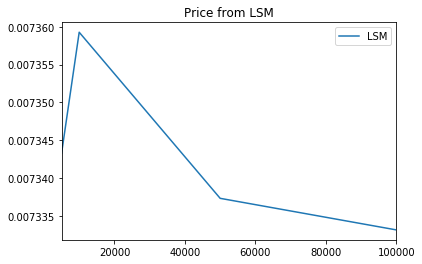

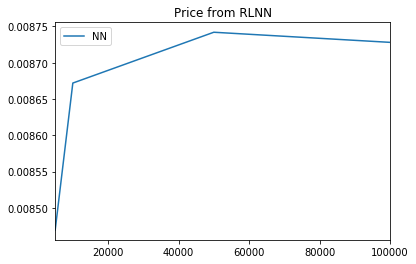

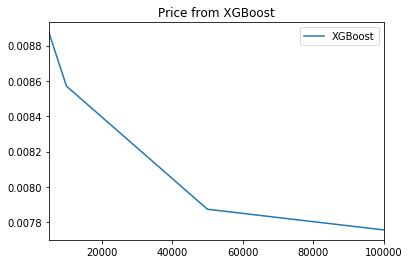

In [180]:
import matplotlib.pyplot as plt

output_table.plot(kind='line',y='LSM',title='Price from LSM')
plt.show()
output_table.plot(kind='line',y='NN',title='Price from RLNN')
plt.show()
output_table.plot(kind='line',y='XGBoost',title='Price from XGBoost')
plt.show()

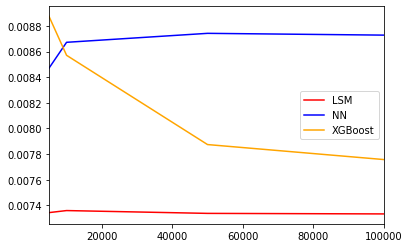

In [181]:
ax=plt.gca()
output_table.plot(kind='line',y='LSM',color='red',ax=ax)
output_table.plot(kind='line',y='NN',color='blue',ax=ax)
output_table.plot(kind='line',y='XGBoost',color='orange',ax=ax)

In [182]:
output_table.to_csv('output_008_1027.csv',index=False)